# Univariate Regression 

In [2]:
import scipy.stats as stats
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [4]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)


infx = ['Chlamydia', 'Tuberculosis', 'Gonorrhea', 'HIV', 'senior_flu_deaths', 'Measles', 'Mumps', 'Pertussis', 'Rubella', 'varicella_hospitalizations', 'Salmonellosis', 'ecoli_hem', 'ecoli_nonhem', 'syphilis', 'botulism_dtfood']
qi = ['mort_30_ami', 'mort_30_cabg', 'mort_30_copd', 'mort_30_hf', 'mort_30_pn', 'mort_30_stk', 'readm_30_ami', 'readm_30_cabg', 'readm_30_copd', 'readm_30_hf', 'readm_30_hip_knee', 'readm_30_hosp_wide', 'readm_30_pn', 'readm_30_stk']
health_and_access = ['PC_PHYS_R', 'DENTIST_R', 'PSYCH_R','n_hospitals','cnty_obesity_pct_adj', 'cnty_dm_pct_adj', 'cnty_inactive_pct_adj', 'Adolescent_births', 'ABR', 'opiods_rx_1000', 'opiods_greater_than_stateavg','std', 'vaccine_dx', 'food_dx']
race = ['PCT_HSPNC', 'PCT_BLACK', 'PCT_ASIAN', 'PCT_AMIND_ESK', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER']
age = [ 'PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5']
social = ['total_housing_units', 'pop_in_group_housing', 'pop_effected', 'p_hs_edatt','MILK_PRICE10', 'SODA_PRICE10', 'MILK_SODA_PRICE10', 'PCH_FFR_07_12', 'FFR07', 'FFR12']
base = ['County','des_percent', 'perc_lali']


df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
df = df.drop(race+infx, axis=1)
cols = df.columns.tolist()
df.head()

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_lali,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800


Before we can compare counties, we need to perform some preprocessing. This is neccessary because our counties vary considerably in size. If we left our data as is, the values of larger counties would dominate our results, and reaffirm the obvious (larger counties are likely to have more food deserts). Below we will calculate the percentage values of our count based features to address this issue. 

It is important to note, this will slightly change how we interpret our results. 
Instead of finding the correlations between varying counts, we will recieve the correlations between varying percentages. 

Again, this is because the  coefficients of our explanatory variables provide the change in response variable for a given one unit increase in the explanatory variable. Since we are changing our explanatory variable to percentages, we will interpret them as such. 

In addition to calculating percentages, we also drop some columns to slim down our dataframe.

In [5]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

df[['total_housing_units', 'pop_in_group_housing']] = df[['total_housing_units', 'pop_in_group_housing']].div(df.POP2010, axis=0)
df['urban_des'] = df['urban_des'].div(df.n_urban, axis=0)
df['rural_des']=df['rural_des'].div(df.n_rural, axis=0)
df[['n_rural','n_urban','LowIncomeTracts','low_vehicle_tracts']] = df[['n_rural','n_urban','LowIncomeTracts','low_vehicle_tracts']].div(df.n_tracts, axis=0)

drop= ['POP2010','n_tracts','opiods_greater_than_stateavg','MILK_SODA_PRICE10', 'PCH_FFR_07_12','FFR12']
drop = drop
keep = [c for c in cols if c not in drop]
df=df[keep].fillna(0)

cols = df.columns.tolist()
df = order(df,['des_percent','perc_lali']).set_index('County')
df.head()

,des_percent,perc_lali,food_deserts,urban_des,rural_des,n_urban,n_rural,LowIncomeTracts,low_vehicle_tracts,total_housing_units,...,readm_30_pn,readm_30_stk,std,vaccine_dx,food_dx,opiods_rx_1000,MILK_PRICE10,SODA_PRICE10,FFR07,pct_nonwhite
County,,,,,,,,,,,,,,,,,,,,,
Alameda,0.041667,0.018032,15,0.042373,0.000000,0.983333,0.016667,0.425000,0.147222,0.360954,...,0.178778,0.134500,619.888748,41.648155,29.597337,557.20,1.122215,1.164422,1112.0,0.483413
Alpine,0.000000,0.266288,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.422979,...,0.000000,0.000000,0.000000,0.000000,0.000000,578.68,1.032918,1.089488,2.0,0.310400
Amador,0.000000,0.149514,0,0.000000,0.000000,0.000000,1.000000,0.222222,0.222222,0.382479,...,0.157000,0.114000,199.522197,15.751752,13.126460,1244.76,1.032918,1.089488,18.0,0.055533
Butte,0.274510,0.145583,14,0.342105,0.076923,0.745098,0.254902,0.627451,0.254902,0.398264,...,0.178750,0.127667,395.000000,15.909091,27.727273,1389.20,0.996443,1.130546,149.0,0.096562
Calaveras,0.000000,0.203345,0,0.000000,0.000000,0.200000,0.800000,0.200000,0.100000,0.414367,...,0.166000,0.144000,120.672254,19.746369,10.970205,1068.98,1.032918,1.089488,27.0,0.060800


In [6]:
df.columns

Index([u'des_percent', u'perc_lali', u'food_deserts', u'urban_des',
       u'rural_des', u'n_urban', u'n_rural', u'LowIncomeTracts',
       u'low_vehicle_tracts', u'total_housing_units', u'pop_in_group_housing',
       u'pop_effected', u'state_pop_ratio', u'state_tract_ratio',
       u'cnty_obesity_pct_adj', u'cnty_dm_pct_adj', u'cnty_inactive_pct_adj',
       u'Adolescent_births', u'ABR', u'p_hs_edatt', u'PC_PHYS_R', u'DENTIST_R',
       u'PSYCH_R', u'PCT_WHITE', u'PCT_65OVER', u'PCT_18_64', u'PCT_UNDR18',
       u'PCT_UNDER5', u'unemployment_rate', u'n_hospitals', u'mort_30_ami',
       u'mort_30_cabg', u'mort_30_copd', u'mort_30_hf', u'mort_30_pn',
       u'mort_30_stk', u'readm_30_ami', u'readm_30_cabg', u'readm_30_copd',
       u'readm_30_hf', u'readm_30_hip_knee', u'readm_30_hosp_wide',
       u'readm_30_pn', u'readm_30_stk', u'std', u'vaccine_dx', u'food_dx',
       u'opiods_rx_1000', u'MILK_PRICE10', u'SODA_PRICE10', u'FFR07',
       u'pct_nonwhite'],
      dtype='object')

### EDA

Before moving forward, lets refresh our memory of what our dataset looks like. This EDA is an important step, and will help us identify interesting relationships that we would like to explore further. Below is a list of plots that can help us gain a better understanding of our dataset:

* distplot - contains a histogram that shows the frequencies of observations as well as a kernel density estimate. One advantage of using seaborn's distplot is that it allows us to test the distribution shape of a feature by setting kde=False, and fit=scipy.stats.distribution. The  probability density function (PDF), that is passed to fit shows the probability of values in the distribution.   

* heatmap - provides a quick means for assessing how variables relate to one another. Depicts a correlation matrix that shows the magnitude and direction of correlations that exist between the included features.   

* pairplot - provdes pairwise scatter plots for every variable passed in, as well as a kde or histogram of the each features distribution. This helps us select the most meanigful features in our data set, and identify any nonlinear relationships. One word of caution - this plot is very computationally expensive, so it is best to limit the number of features passed in to 6 or less.

* boxplot - helps to assess categorical variables, and the presence of outliers. 


μ represents the mean (which coincides with the median and the mode) and the symbol σ is the variance.

### Assessing the Distributions of Target Variables

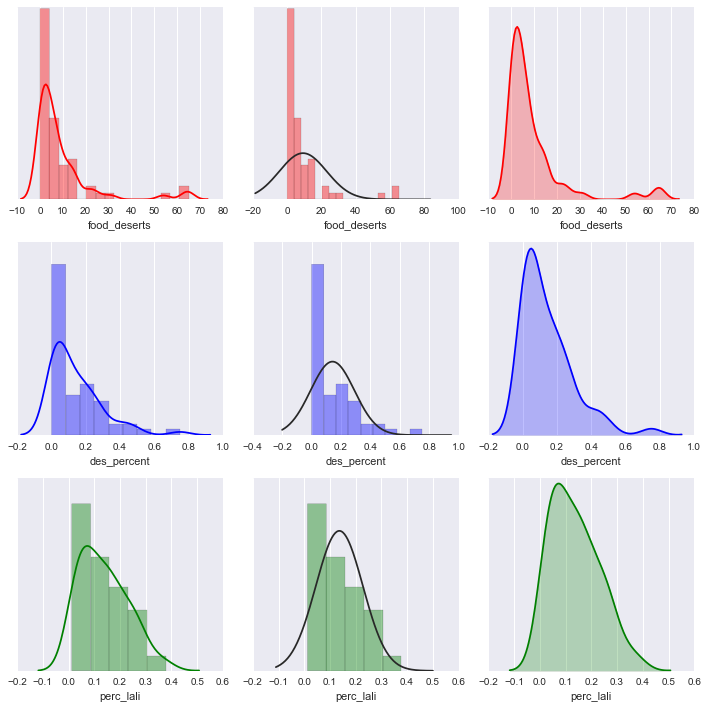

In [7]:
from scipy.stats import norm

f, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.despine(left=True)

d = df['food_deserts']
d2 = df['des_percent']
d3 = df['perc_lali']


sns.distplot(d, color="r", ax=axes[0, 0])
sns.distplot(d, color="r", fit=norm, kde=False, ax=axes[0, 1])
sns.distplot(d, hist=False, color="r", kde_kws={"shade": True}, ax=axes[0, 2])

sns.distplot(d2, color="b", ax=axes[1, 0])
sns.distplot(d2, color="b", fit=norm, kde=False, ax=axes[1, 1])
sns.distplot(d2, hist=False, color="b", kde_kws={"shade": True}, ax=axes[1, 2])

sns.distplot(d3, color="g", ax=axes[2, 0])
sns.distplot(d3, color="g", fit=norm, kde=False, ax=axes[2, 1])
sns.distplot(d3, hist=False, color="g", kde_kws={"shade": True}, ax=axes[2, 2])

plt.setp(axes, yticks=[])
plt.tight_layout()

### Obtaining a broad look at Feature relationships

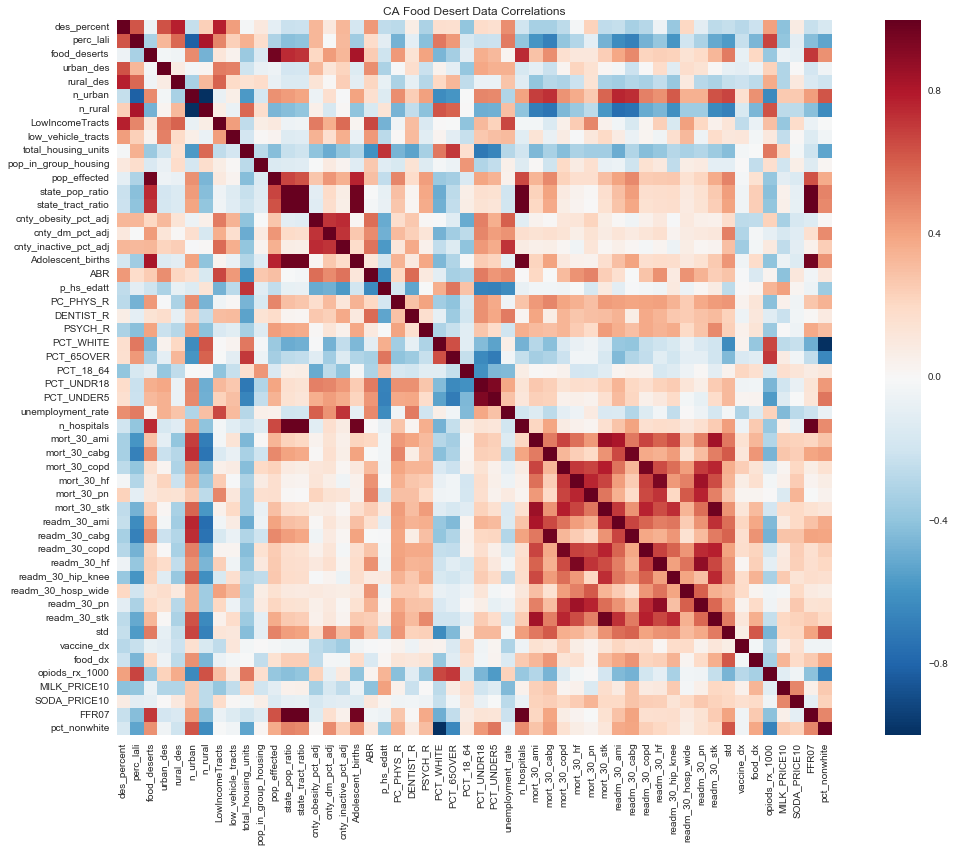

In [8]:
def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)


data = standardize(df)

# generates a correllation matrix using pandas
corrmat = data.corr()

# Sets up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Drawa the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

### A closer look at selected features

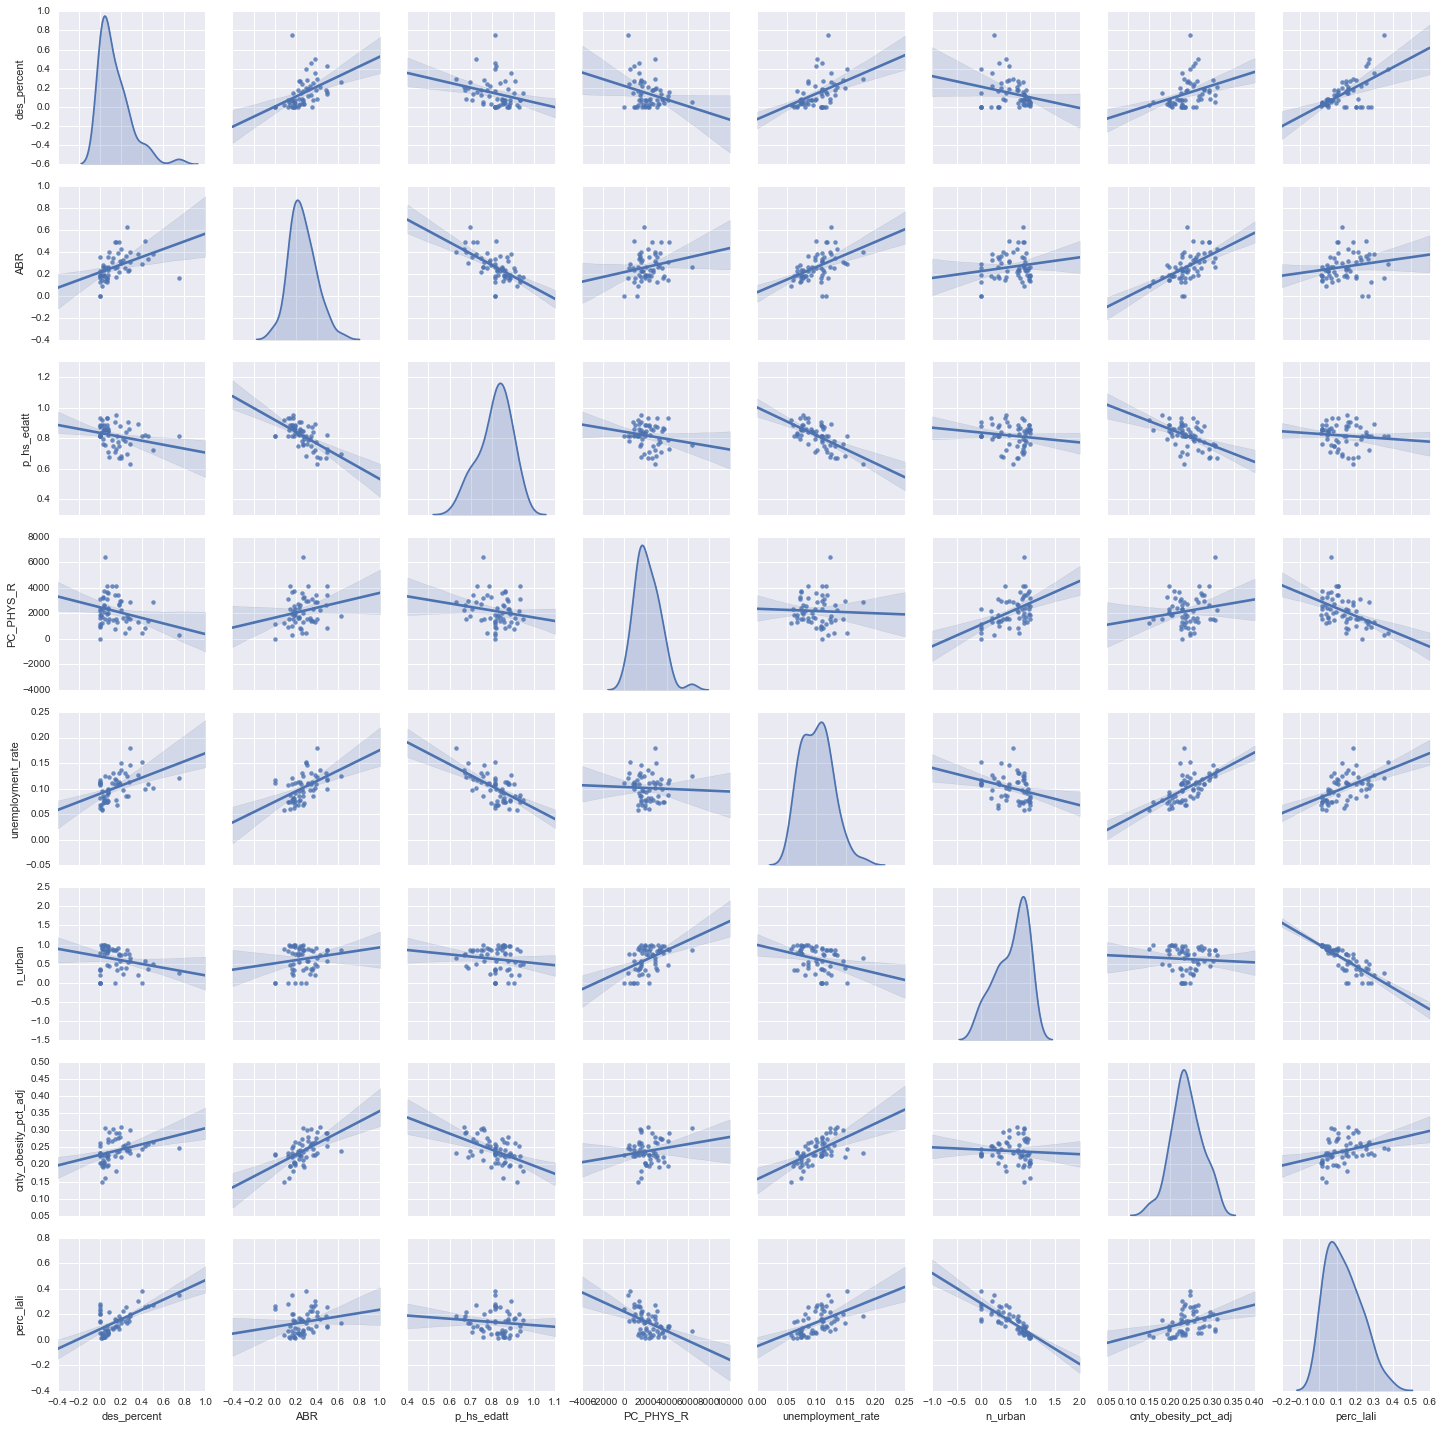

In [9]:
pairs=df[['des_percent','ABR','p_hs_edatt','PC_PHYS_R','unemployment_rate','n_urban','cnty_obesity_pct_adj','perc_lali']]
g = sns.pairplot(pairs, diag_kind="kde", kind='reg',
                 diag_kws=dict(shade=True))

## Univariate Regression

##### x = County obesity rates (age-adjusted)
##### y = County Food desert prevelance (percentage of County census tracts that were labled as "food deserts")


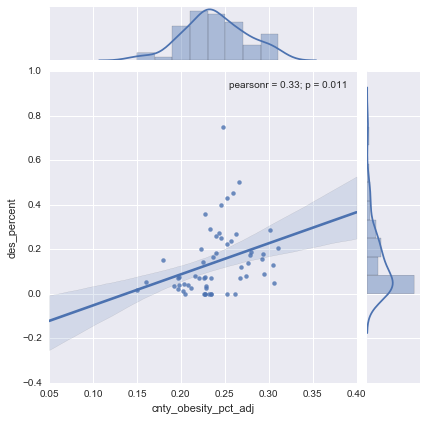

In [10]:
sns.jointplot(x='cnty_obesity_pct_adj', y='des_percent', data=df, kind='reg')

In [11]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)


print ('Homemade correlation function: %0.5f' % (correlation(df['cnty_obesity_pct_adj'], df['des_percent'])))
print ('Scipys pearsonr function with correlation and p-val: %0.5f & %0.5f' % pearsonr(df['cnty_obesity_pct_adj'], df['des_percent']))


Homemade correlation function: 0.32989
Scipys pearsonr function with correlation and p-val: 0.32989 & 0.01144


In [12]:
X=df['cnty_obesity_pct_adj']
y=df['des_percent']
X = sm.add_constant(X) # adds bias

lr_model1 = sm.OLS(y,X).fit()
lr_model2 = smf.ols(formula='des_percent ~ cnty_obesity_pct_adj', data=df).fit()

# The line below will provide identical output to our first model.
#lr_model2.summary() 
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            des_percent   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.839
Date:                Mon, 08 Aug 2016   Prob (F-statistic):             0.0114
Time:                        11:53:05   Log-Likelihood:                 31.321
No. Observations:                  58   AIC:                            -58.64
Df Residuals:                      56   BIC:                            -54.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -0.1919      0.129     -1.486      0.143        -0.451     0.067
cnty_obesity_pct_adj     1.3950      0.533      2.615      0.011         0.326     2.464
==============================================================================
Omnibus:                       32.270   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.801
Skew:                           1.754   Prob(JB):                     6.96e-16
Kurtosis:                       7.071   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### First Table
##### Baseline model information
• Dep. Variable - The model's target variable   
• Model: The type of model made (OLS ='s ordinary least squares)   
• No. Observations: The number of observations the model was trained on.   
• DF Residuals: The number of observations minus the number of parameters. We have 56 because we passed in 58 observations, and 2 parameters (obesity rates, and contant). 58-2 = 56   
• DF Model: The number of explanatory variables, excluding the constant.    
##### Goodness of model fit
• R-squared: Also reffered to as the coefficient of determination, and reflects how close the data are to the fitted regression line. It signifies how much more variance the model explains in comparison what is unexplained by the mean.    
• Adj. R-squared: The adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance. ( http://blog.minitab.com/blog/adventures-in-statistics/multiple-regession-analysis-use-adjusted-r-squared-and-predicted-r-squared-to-include-the-correct-number-of-variables)    
• F-statistic: Reflects whether the explanatory variables coefficients are different from zero. This becomes more important in multivariate regression. The high values suggests strong predictors.     
• Prob (F-statistic): This is the probability that you got that F-statistic was due to chance. Ideally this value should be less than a predefined significance level, such as 0.05.    
• AIC: This is the Akaike Information Criterion, which evaluates model complexity. Lesser is better. Becomes useful during model comparison.  
• BIC: This is the Bayesian Information Criterion. Similiar to AIC, but penalizes models with high paramaters more severly.   

### Second Table
##### Explanatory Variable Statistics
• coef: The estimated coefficient of the beta or the explantory variables. The coefficient of our explanatory variable, obesity rate, provides the change in county food desert prevelance for every unit increase in obesity rate. So if the coeff is 1.3950, and the constant is -0.191870, we would use the following formula to predict the percentage of county census tracts that are food deserts:   
$$ food deserts prev = 1.3950 * x_{obesity prev} * -0.191870$$
• std err: The standard error of the explanatory variables coef, which reflects how confident we can be in the coef. Higher values reflect more uncertainty   
• t: The t-statistic value, reflects whether the coefficent is not zero.   
• P > |t|: The probability that the coefficient is different from zero just by chance    
• [95.0% Conf. Interval]: "The lower and upper values of the coefficient, considering 95% of all the chances of having different observations and so different estimated coefficients"  

### Bottom Table
##### Model Residuals (difference between predictions an actual response variable values)
• Skewness: Refects the symmetry of residuals. Postive values = right tail, Negative values = left tail, Close to Zero values = symmetric.    
• Kurtosis: The distribution shape of the residuals. Postive values = high peak, Negative values = flat, Close to Zero values = bell shaped.    
• Omnibus D'Angostino's test: Mix of the tests above  
• Prob(Omnibus): The probility of the Omnibus statistic  
• Jarque-Bera: Also reflects skewness and kurtosis.  
• Prob (JB): The probility of the JB statistic.  
• Durbin-Watson: Tests for correlation among the residuals, used with Time series data.   
• Cond. No: This is a test for multicollinearity. Important in multivariate analysis.  

Statsmodels allows us to access the coeffcients with the params method, and the predictions of the model with .predict(data).  


In [13]:
print (lr_model1.params)
betas = np.array(lr_model1.params)
fitted_values =lr_model1.predict(X)


const                  -0.191870
cnty_obesity_pct_adj    1.394967
dtype: float64




Using our model's predictions we can calculate the R squared value manually. This is done by calculating the following: 

* SSD - The unexplained variance of county food desert prevelance (the sum of squared differences from the mean). 
* SSR - The regression sum of squares, the difference between the actual and predcicted values (regresion sum of squares) 
* R squared - the amount of variance explaine by the model,  SSD - SSR / SSD

Predictive Analytics p. 149

In [14]:
mean_sum_squared_errors = np.sum((df['des_percent']-df['des_percent'].mean())**2)
regr_sum_squared_errors = np.sum((df['des_percent']-fitted_values)**2)
r2 = (mean_sum_squared_errors - regr_sum_squared_errors) / mean_sum_squared_errors
print("SSD = {}\nSSR = {}\nR2 = {}").format(mean_sum_squared_errors,regr_sum_squared_errors,r2)

SSD = 1.29399927468
SSR = 1.15317513283
R2 = 0.108828609571


Lets visualize our model in a dataframe and some plots

In [15]:
lr_pred = pd.DataFrame({'cnty_obesity_pct_adj':X['cnty_obesity_pct_adj'],'Predicted_Output(des_percent)':fitted_values,'Actual_Output(des_percent)':y})
lr_pred['mean'] = lr_pred['Actual_Output(des_percent)'].mean()
lr_pred.head()

,Actual_Output(des_percent),Predicted_Output(des_percent),cnty_obesity_pct_adj,mean
County,,,,
Alameda,0.041667,0.092703,0.204,0.142248
Alpine,0.000000,0.131762,0.232,0.142248
Amador,0.000000,0.126182,0.228,0.142248
Butte,0.274510,0.147107,0.243,0.142248
Calaveras,0.000000,0.161056,0.253,0.142248


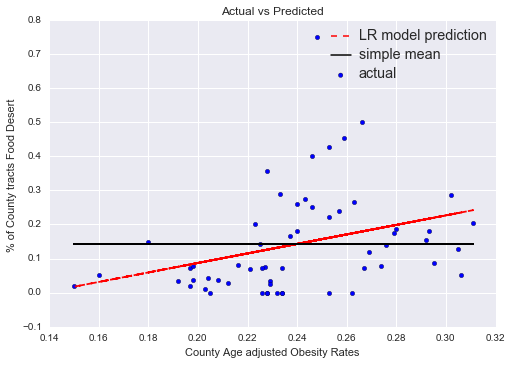

In [16]:

xval = lr_pred['cnty_obesity_pct_adj']
xp = lr_pred['Predicted_Output(des_percent)']
yval = lr_pred['Actual_Output(des_percent)']
m = lr_pred['mean']


fig, ax = plt.subplots()
ax.plot(xval, xp, 'k--', color='r',label='LR model prediction')
plt.scatter(xval, yval, label='actual')
ax.plot(xval, m, 'k', label='simple mean')

legend = ax.legend(loc='best', shadow=True)

frame = legend.get_frame()
frame.set_facecolor('0.90')

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  
    
ax.set_xlabel('County Age adjusted Obesity Rates')
ax.set_ylabel('% of County tracts Food Desert ')
plt.title('Actual vs Predicted')
plt.show()

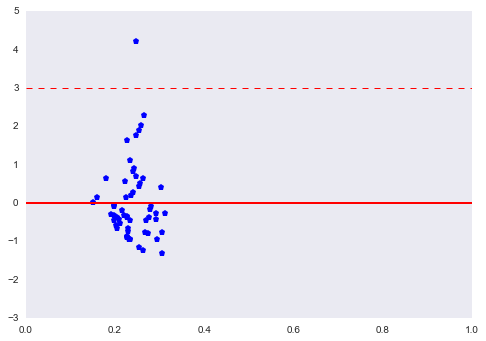

In [17]:
residuals = lr_pred['Actual_Output(des_percent)']-fitted_values
normalized_residuals = standardize(residuals)
x_range = [lr_pred['Actual_Output(des_percent)'].min(),lr_pred['Actual_Output(des_percent)'].max()]
residual_scatter_plot = plt.plot(lr_pred['cnty_obesity_pct_adj'], normalized_residuals,'bp')
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0],'-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3],'--', color='red', linewidth=1)
plt.grid()

"The resulting scatterplot indicates that the residuals show some of the problems
we previously indicated as a warning that something is not going well with your regression analysis. First, there are a few points lying outside the band delimited by the two dotted lines at normalized residual values −3 and +3 (a range that should hypothetically cover 99.7% of values if the residuals have a normal distribution). These are surely in uential points with large errors and they can actually make the entire linear regression under-perform."

p. 52 Regression

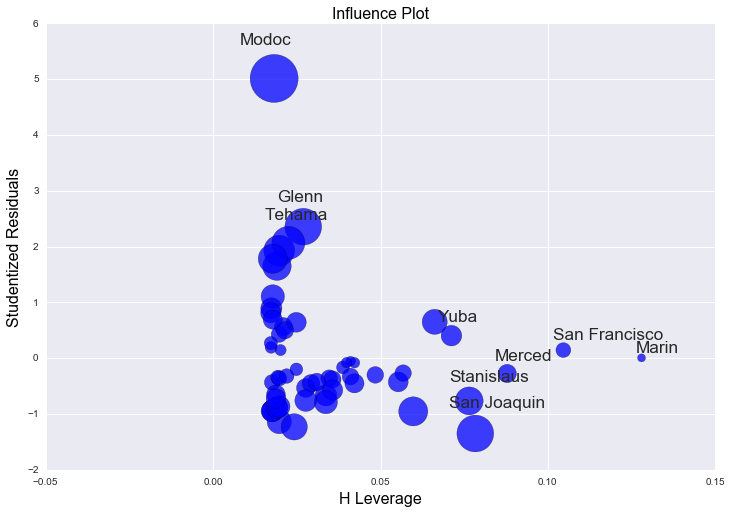

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lr_model1, ax=ax, criterion="cooks")

In [19]:
print "Dataset means: \n",df[['des_percent','cnty_obesity_pct_adj']].mean()
print "\nDataset std: \n",df[['des_percent','cnty_obesity_pct_adj']].std()
print "\nModoc values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['Modoc']

Dataset means: 
des_percent             0.142248
cnty_obesity_pct_adj    0.239517
dtype: float64

Dataset std: 
des_percent             0.150671
cnty_obesity_pct_adj    0.035632
dtype: float64

Modoc values : 
des_percent             0.750
cnty_obesity_pct_adj    0.248
Name: Modoc, dtype: float64


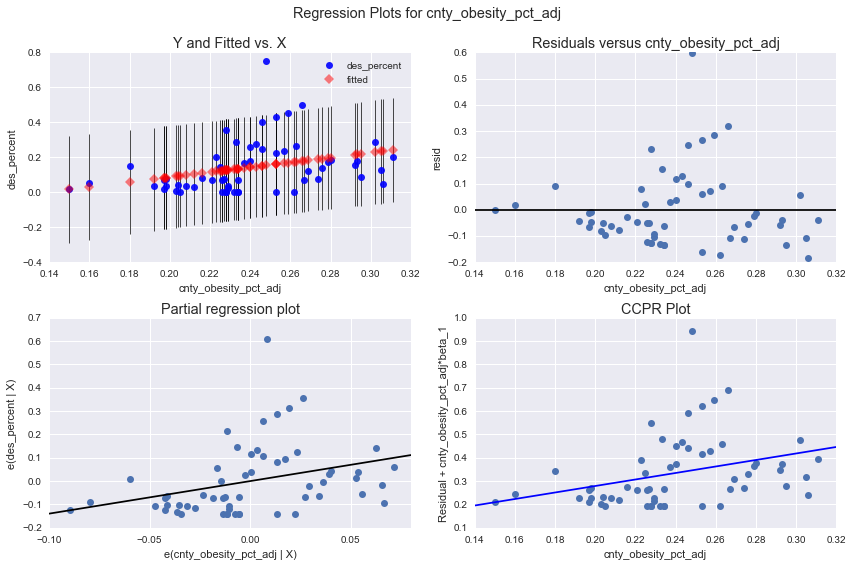

In [20]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(lr_model1, "cnty_obesity_pct_adj", fig=fig)

The first thing we must do is define our dependent and indepent variables. 

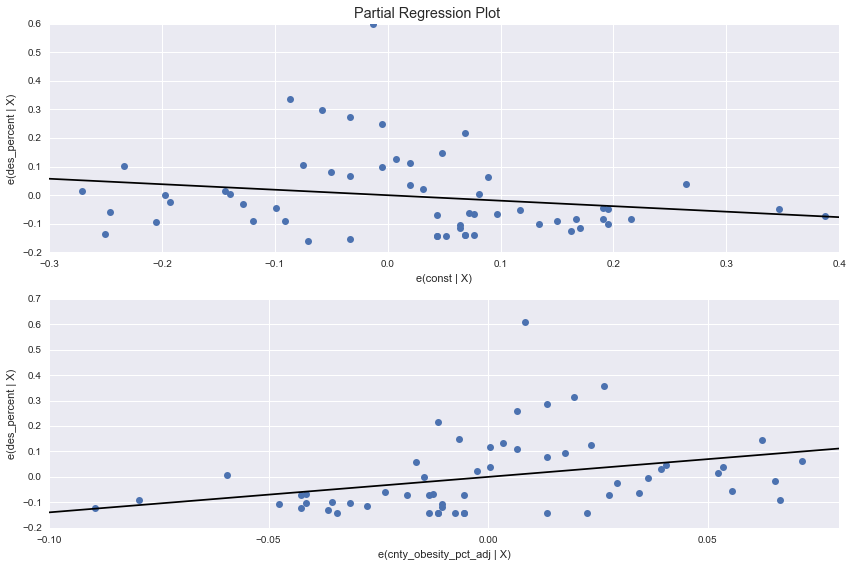

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(lr_model1, fig=fig)

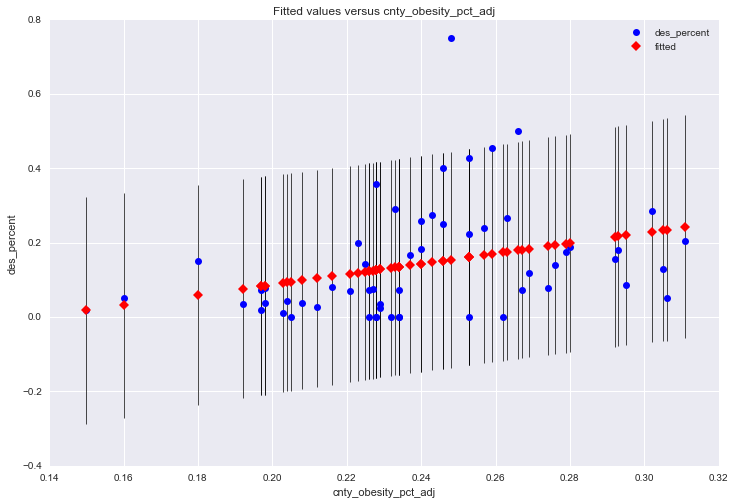

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(lr_model1, "cnty_obesity_pct_adj", ax=ax)

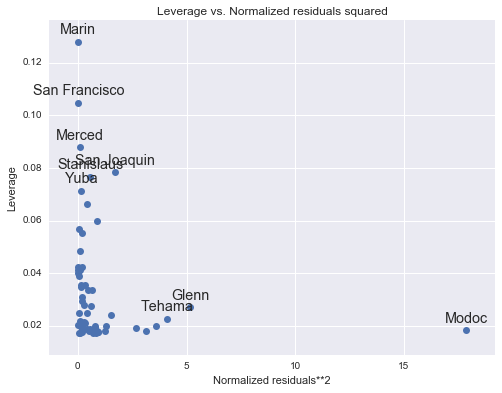

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_leverage_resid2(lr_model1, ax=ax)

In [24]:
print "\tDataset means: \n",df[['des_percent','cnty_obesity_pct_adj']].mean()
print "\n\tDataset std: \n",df[['des_percent','cnty_obesity_pct_adj']].std()
print "\n\tModoc values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['Modoc']
print "\n\tMarin values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['Marin']
print "\n\tSan Francisco values : \n", df[['des_percent','cnty_obesity_pct_adj']].ix['San Francisco']

	Dataset means: 
des_percent             0.142248
cnty_obesity_pct_adj    0.239517
dtype: float64

	Dataset std: 
des_percent             0.150671
cnty_obesity_pct_adj    0.035632
dtype: float64

	Modoc values : 
des_percent             0.750
cnty_obesity_pct_adj    0.248
Name: Modoc, dtype: float64

	Marin values : 
des_percent             0.018182
cnty_obesity_pct_adj    0.150000
Name: Marin, dtype: float64

	San Francisco values : 
des_percent             0.051282
cnty_obesity_pct_adj    0.160000
Name: San Francisco, dtype: float64


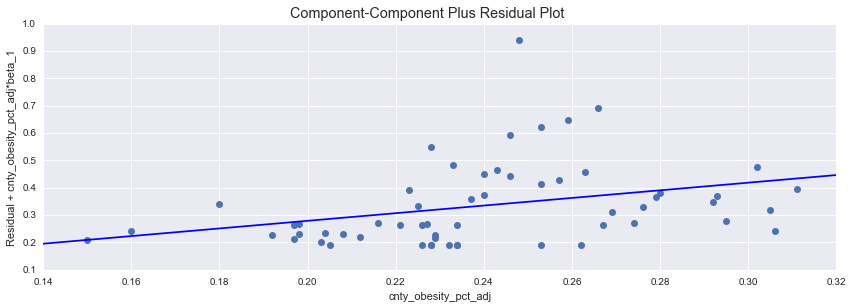

In [25]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(lr_model1, fig=fig)

In [26]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)





Minimizing the Cost Function
---
At the core of linear regression, there is the search for a line's equation that it is able to minimize the sum of the squared errors of the difference between the line's y values and the original ones.

In [27]:
def squared_cost(v,e):
    return np.sum((v-e)**2)

In [28]:
import random

def random_w( p ):
    return np.array([np.random.normal() for j in range(p)])

def hypothesis(X,w):
    return np.dot(X,w)

def loss(X,w,y):
    return hypothesis(X,w) - y

def squared_loss(X,w,y):
    return loss(X,w,y)**2

def gradient(X,w,y):
    gradients = list()
    n = float(len( y ))
    for j in range(len(w)):
        gradients.append(np.sum(loss(X,w,y) * X[:,j]) / n)
    return gradients

def update(X,w,y, alpha=0.01):
    return [t - alpha*g for t, g in zip(w, gradient(X,w,y))]

def optimize(X,y, alpha=0.01, eta = 10**-12, iterations = 1000):
    w = random_w(X.shape[1])
    path = list()
    for k in range(iterations):
        SSL = np.sum(squared_loss(X,w,y))
        new_w = update(X,w,y, alpha=alpha)
        new_SSL = np.sum(squared_loss(X,new_w,y))
        w = new_w
        if k>=5 and (new_SSL - SSL <= eta and new_SSL - SSL >= -eta):
            path.append(new_SSL)
            return w, path
        if k % (iterations / 20) == 0:
            path.append(new_SSL)    
    return w, path


In [29]:
observations = len(df)
X  = df['cnty_obesity_pct_adj'].values.reshape((observations,1))
# X should be always a matrix, never a vector
X = np.column_stack((X,np.ones(observations))) # We add the bias
y  = df['perc_lali'].values # y can be a vector

In [30]:
alpha = 0.048
w, path = optimize(X,y,alpha, eta = 10**-12, iterations = 100)
print ("These are our final coefficients: %s" % w)
print ("Obtained walking on this path of squared loss %s" % path)


These are our final coefficients: [-0.58730424138546522, 0.26771503450511069]
Obtained walking on this path of squared loss [170.85287758978117, 101.72122282984029, 60.658133393636817, 36.267305523278182, 21.779524094328707, 13.17398776852939, 8.0624073418015207, 5.0261786995715241, 3.2226745626727773, 2.1513883244290422, 1.5150273745439486, 1.1370048409160027, 0.91243105484860754, 0.77900329548177105, 0.69971478154460132, 0.65258409968293485, 0.62455465549380473, 0.60787104877814835, 0.59792670063414033, 0.59198537970441178]


In [31]:
X = df['cnty_obesity_pct_adj'].values
X  = df['cnty_obesity_pct_adj'].values.reshape((observations,1))
# X should be always a matrix, never a vector
X = np.column_stack((X,np.ones(observations))) # We add the bias

In [32]:
observations = len(df)
#variables = 'pop2010_in_des
standardization = StandardScaler()
Xst = standardization.fit_transform(X)
original_means = standardization.mean_
originanal_stds = standardization.std_
Xst = np.column_stack((Xst,np.ones(observations)))
y  = df['perc_lali'].values

/Users/desert/anaconda/envs/linreg/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function std_ is deprecated; Attribute ``std_`` will be removed in 0.19. Use ``scale_`` instead
  warnings.warn(msg, category=DeprecationWarning)


In [33]:
alpha = 0.02
w, path = optimize(Xst, y, alpha, eta = 10**-12, iterations = 200)
print ("These are our final standardized coefficients: " + ', '.join(map(lambda x: "%0.4f" % x, w)))

These are our final standardized coefficients: 0.0440, -0.0537, 0.1221


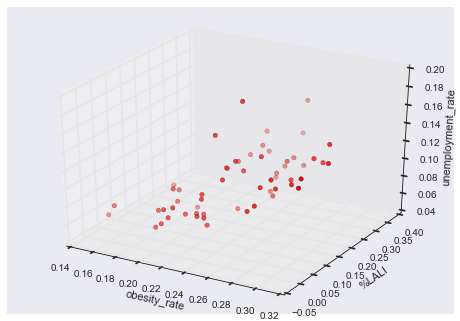

(58, 2)

In [34]:
z=df['unemployment_rate'].values
x=df['cnty_obesity_pct_adj'].values
y = df['perc_lali'].values
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')





ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('obesity_rate')
ax.set_ylabel('%LALI')
ax.set_zlabel('unemployment_rate')

plt.show()
len(x)
np.shape(X)

In [35]:
from statsmodels.stats.anova import anova_lm
##############################################################################
# Multilinear regression model, calculating fit, P-values, confidence
# intervals etc.

# Convert the data into a Pandas DataFrame to use the formulas framework
# in statsmodels

# First we need to flatten the data: it's 2D layout is not relevent.
z=df['unemployment_rate'].values
x=df['cnty_obesity_pct_adj'].values
y = df['perc_lali'].values

# X = X.flatten()
# Y = Y.flatten()
# Z = Z.flatten()

data = pd.DataFrame({'obesity': x, 'fooddesert': y, '%urban': z})

# Fit the model
model = smf.ols("z ~ x + y", data).fit()

# Print the summary
print(model.summary())

print("\nRetrieving manually the parameter estimates:")
print(model._results.params)
# should be array([-4.99754526,  3.00250049, -0.50514907])

# Peform analysis of variance on fitted linear model
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     24.88
Date:                Mon, 08 Aug 2016   Prob (F-statistic):           2.01e-08
Time:                        11:53:11   Log-Likelihood:                 148.66
No. Observations:                  58   AIC:                            -291.3
Df Residuals:                      55   BIC:                            -285.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0041      0.017      0.234      0.8

________

## Baysian Approach - pymc3 

In [59]:
from pymc3 import  *

df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)
df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
df = df.drop(race+infx, axis=1)
cols = df.columns.tolist()

data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]#.astype(int)
data.columns=['x','y']

x=data['x'].values
y=data['y'].values
data=dict(x=x,y=y)
data

{'x': array([ 0.4834125 ,  0.3104    ,  0.05553333,  0.0965625 ,  0.0608    ,
         0.26745   ,  0.34015455,  0.211     ,  0.08314   ,  0.30679286,
         0.24816667,  0.19548   ,  0.32972   ,  0.21666667,  0.24879333,
         0.28806667,  0.10486   ,  0.287625  ,  0.45452222,  0.16276667,
         0.153475  ,  0.1298    ,  0.15491667,  0.34295   ,  0.09866667,
         0.15125   ,  0.2169875 ,  0.16198333,  0.0552    ,  0.35266296,
         0.09608333,  0.05936   ,  0.31228261,  0.35118125,  0.2683    ,
         0.27970385,  0.23263158,  0.4634625 ,  0.31498   ,  0.12374   ,
         0.3109    ,  0.2030125 ,  0.4607    ,  0.10546667,  0.0784875 ,
         0.0665    ,  0.088725  ,  0.35223333,  0.14063333,  0.20886667,
         0.25623333,  0.1241    ,  0.061175  ,  0.19783333,  0.13845   ,
         0.2652    ,  0.27345   ,  0.16903333]),
 'y': array([15,  0,  0, 14,  0,  1, 15,  3,  3, 31,  3,  8,  9,  1, 21,  7,  0,
         2, 65,  2,  1,  0,  5, 10,  3,  0,  7,  0,  3,  6,  6

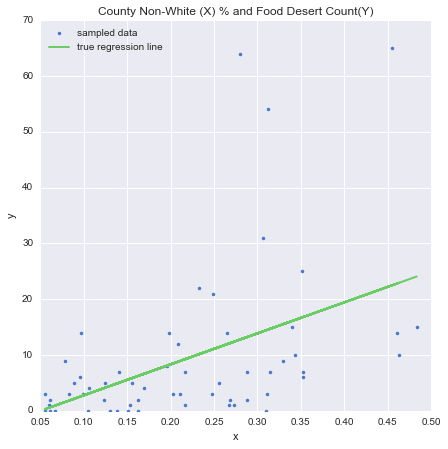

In [60]:

model1=smf.ols(formula='food_deserts ~ pct_nonwhite',data=df).fit()
model1.params
pred=model1.predict(pd.DataFrame(df['pct_nonwhite']))
true_regression_line = pred

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='County Non-White (X) % and Food Desert Count(Y)')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [61]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x', data)
    start = find_MAP()
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, progressbar=False) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log to model.


Bayesian Regression does not provide a singular best fit line. Instead it provides a posterior distribution of likely parameters. Below plots the posterior distribution of our parameters and the individual samples were drawn. I
(http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)

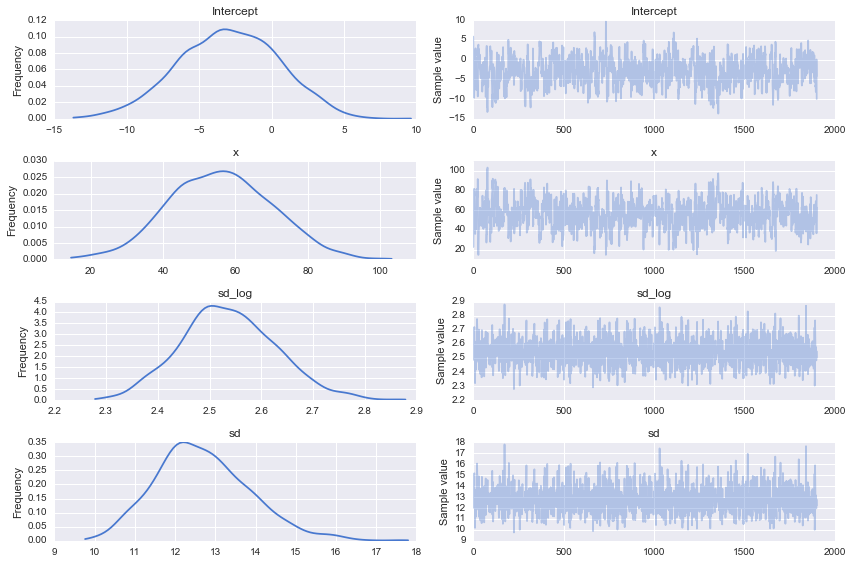

In [62]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [63]:
model1.params
# x looks similiar to x's coef in linear model
# sd looks similiar to np.std(y), the std of target

Intercept       -2.775976
pct_nonwhite    55.518390
dtype: float64

The left side shows our marginal posterior -- for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).

(http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)

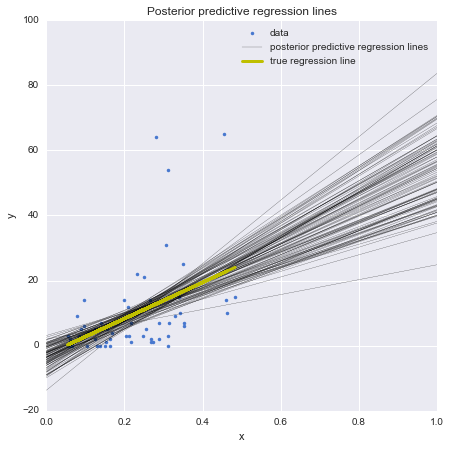

In [64]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

In the GLM we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. 

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have uncertainty in our estimates, here expressed by the variability of the lines.
(http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
_______

Applied log-transform to lam and added transformed lam_log to model.


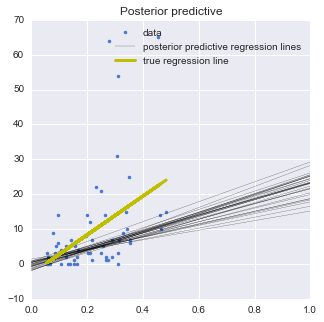

In [65]:
with Model() as model_robust:
    family = glm.families.StudentT()
    glm.glm('y ~ x', data, family=family)
    start = find_MAP()
    step = NUTS(scaling=start)
    trace_robust = sample(2000, step, progressbar=False)

plt.figure(figsize=(5, 5))
#plt.plot(x_out, y_out, 'x')
plt.plot(x, y, '.', label='data')

glm.plot_posterior_predictive(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')
plt.legend();



Avoids outliers

In [208]:
import pymc3 as pm 

ur=pd.read_csv('/Users/desert/desert_workspace/desert_data/urban_rural_data.csv')
ur = ur.drop('Unnamed: 0', axis=1)

ur
county_names = ur.County.unique()
county_idx = ur.index
n_counties = len(ur.County.unique())
data = ur
data.describe()
len(county_idx.values)

8044

In [203]:
indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.ix[data.County == county_name]
    c_Rural = c_data.Rural
    c_fd = c_data.LILATracts_1And10.values
    
    with pm.Model() as individual_model:
        # Intercept prior (variance == sd**2)
        a = pm.Normal('alpha', mu=0, sd=100**2)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=100**2)
    
        # Model error prior
        eps = pm.Uniform('eps', lower=0, upper=100)
    
        # Linear model
        fd_est = a + b * c_Rural
    
        # Data likelihood
        radon_like = pm.Normal('radon_like', mu=fd_est, sd=eps, observed=c_fd)

        # Inference button (TM)!
        step = pm.NUTS()
        trace = pm.sample(2000, step=step, progressbar=True)
    
    # keep trace for later analysis
    indiv_traces[county_name] = trace

Applied interval-transform to eps and added transformed eps_interval to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 10.9 secApplied interval-transform to eps and added transformed eps_interval to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 63.3 secApplied interval-transform to eps and added transformed eps_interval to model.


KeyboardInterrupt: 

In [204]:
'test'

'test'

In [205]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    fd_est = a[county_idx] + b[county_idx] * data.rural.values
    
    # Data likelihood
    fd_like = pm.Normal('radon_like', mu=fd_est, sd=eps, observed=datadata.LILATracts_1And10.values)

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval to model.
Applied interval-transform to eps and added transformed eps_interval to model.


IndexError: index 58 is out of bounds for axis 1 with size 58

In [71]:
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate

import pymc3 as pm
import theano as thno
import theano.tensor as T

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

In [72]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    '''
    Create a toy dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optionally create labelled outliers with larger noise

    Model form: y ~ a + bx + cx^2 + e

    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process'
    generating thses values, rather than experimental measurement error.
    Please don't use the returned `latent_error` values in inferential
    models, it's returned in e dataframe for interest only.
    '''

    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})

    ## create linear or quadratic model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2

    ## create latent noise and marked outliers
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
    df['outlier'] = rndst.binomial(1,p,n)

    ## add noise, with extreme noise for marked outliers
    df['y'] += ((1-df['outlier']) * df['latent_error'])
    df['y'] += (df['outlier'] * df['outlier_error'])

    ## round
    for col in ['y','latent_error','outlier_error','x']:
        df[col] = np.round(df[col],3)

    ## add label
    df['source'] = 'linear' if c == 0 else 'quadratic'

    ## create simple linspace for plotting true model
    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2
    dfp = pd.DataFrame({'x':plotx, 'y':ploty})

    return df, dfp


def interact_dataset(n=20, p=0, a=-30, b=5, c=0, latent_sigma_y=20):
    '''
    Convenience function:
    Interactively generate dataset and plot
    '''

    df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False]
                    ,palette=sns.color_palette('Set1'), legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              ,ms=10, mec='w', mew=2, ls='', elinewidth=0.7).add_legend()

    _ = plt.plot(dfp['x'], dfp['y'], '--', alpha=0.8)

    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(df['source'][0])
                       ,fontsize=16)


def plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad):
    '''
    Convenience function:
    Plot the two generated datasets in facets with generative model
    '''

    df = pd.concat((df_lin, df_quad), axis=0)
    dfp_lin, dfp_quad

    g = sns.FacetGrid(col='source', hue='source', data=df, size=6
                      ,sharey=False, legend_out=False)

    _ = g.map(plt.scatter, 'x', 'y', alpha=0.7, s=100, lw=2, edgecolor='w')

    _ = g.axes[0][0].plot(dfp_lin['x'], dfp_lin['y'], '--', alpha=0.6)
    _ = g.axes[0][1].plot(dfp_quad['x'], dfp_quad['y'], '--', alpha=0.6)


def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')


def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j)
                                     for j in range(2,k+1)])).strip()


def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

    return models, traces


def plot_posterior_cr(models, traces, rawdata, xlims,
                      datamodelnm='linear', modelnm='k1'):
    '''
    Convenience function:
    Plot posterior predictions with credible regions shown as filled areas.
    '''

    ## Get traces and calc posterior prediction for npoints in x
    npoints = 100
    mdl = models[modelnm]
    trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
    trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

    ordr = int(modelnm[-1:])
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
    X = x ** pwrs
    cr = np.dot(X,trc.T)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Greens')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
    plt.subplots_adjust(top=0.95)

    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


In [75]:
data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]#.astype(int)
data.columns=['x','y']

# x=data['x'].values
# y=data['y'].values
# data=dict(x=x,y=y)
data

,x,y
0,0.483413,15
1,0.310400,0
2,0.055533,0
3,0.096562,14
4,0.060800,0
5,0.267450,1
6,0.340155,15
7,0.211000,3
8,0.083140,3
9,0.306793,31


In [99]:
latent_sigma_y = 20
n = len(data)
p=0.05
c=0
a=1
b=1
## create latent noise and marked outliers
data['latent_error'] = rndst.normal(0,latent_sigma_y,n)
data['outlier_error'] = rndst.normal(0,latent_sigma_y*10,n)
data['outlier'] = rndst.binomial(1,p,n)

## add noise, with extreme noise for marked outliers
#df['y'] += ((1-df['outlier']) * df['latent_error'])
#df['y'] += (df['outlier'] * df['outlier_error'])

## round
for col in ['y','latent_error','outlier_error','x']:
    data[col] = np.round(data[col],3)

## add label
data['source'] = 'linear' if c == 0 else 'quadratic'

## create simple linspace for plotting true model
plotx = np.linspace(data['x'].min() - np.ptp(data['x'])*.1
                    ,data['x'].max() + np.ptp(data['x'])*.1, 100)
ploty = a + b*plotx + c*plotx**2
dfp = pd.DataFrame({'x':plotx, 'y':ploty})

In [100]:
rndst.binomial(1,p,n)
latent_sigma_y

20

In [101]:
def interact_dataset(n=len(data), p=0, a=-30, b=5, c=0, latent_sigma_y=20, df=data, dfp=dfp):
    '''
    Convenience function:
    Interactively generate dataset and plot
    '''

    #df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)

    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False]
                    ,palette=sns.color_palette('Set1'), legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              ,ms=10, mec='w', mew=2, ls='', elinewidth=0.7).add_legend()

    _ = plt.plot(dfp['x'], dfp['y'], '--', alpha=0.8)

    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(df['source'][0])
                       ,fontsize=16)

In [195]:

data = df.copy()
data = data[['pct_nonwhite', 'food_deserts','n_tracts','POP2010','County']]#.astype(int)
data.columns=['x','y','n','pop','County']
n_count_data = len(data)


def get_obs(ix, var, n_var):
    res = []
    for i in ix:
        res+=([1]*data[var].ix[i] + [0]*(data[n_var].ix[i] - data[var].ix[i]))
    return res

data['x_int'] = np.round(data['x'] * data['pop'])
eth = [get_obs([i],'x_int','pop') for i in list(data.index)]
tracts =[get_obs([i],'y','n') for i in list(data.index)]
tracts
t_df = pd.DataFrame([t for t in tracts]).T
t_df.columns = df.County

pd.pivot_table(data, ['x','POP2010'], index=['n'],
                     columns='County')
# data['x_int'] = np.round(data['x'] * data['pop'])
# data['sigma_y']=[get_obs([i],'y','n') for i in list(data.index)]
# # data['x_int'] = df['x'] * df['pop']
# data['sigma_x']=[get_obs([i],'x_int','pop') for i in list(data.index)]


x                                                              \
County   Alameda  Alpine    Amador     Butte Calaveras   Colusa Contra Costa   
n                                                                              
1            NaN  0.3104       NaN       NaN       NaN      NaN          NaN   
3            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
4            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
5            NaN     NaN       NaN       NaN       NaN  0.26745          NaN   
6            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
7            NaN     NaN       NaN       NaN       NaN      NaN          NaN   
9            NaN     NaN  0.055533       NaN       NaN      NaN          NaN   
10           NaN     NaN       NaN       NaN    0.0608      NaN          NaN   
11           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
14           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
15           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
20           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
21           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
23           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
27           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
30           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
31           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
40           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
41           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
42           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
48           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
49           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
51           NaN     NaN       NaN  0.096562       NaN      NaN          NaN   
52           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
53           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
55           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
78           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
84           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
89           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
93           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
94           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
96           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
99           NaN     NaN       NaN       NaN       NaN      NaN          NaN   
139          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
151          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
156          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
173          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
195          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
199          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
207          NaN     NaN       NaN       NaN       NaN      NaN     0.340155   
317          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
360     0.483413     NaN       NaN       NaN       NaN      NaN          NaN   
368          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
372          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
453          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
582          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
627          NaN     NaN       NaN       NaN       NaN      NaN          NaN   
2334         Na

### interactive(interact_dataset, n=[5,50,5], p=[0,.5,.05], a=[-50,50]
            ,b=[-10,10], c=[-3,3], latent_sigma_y=[0,1000,50])

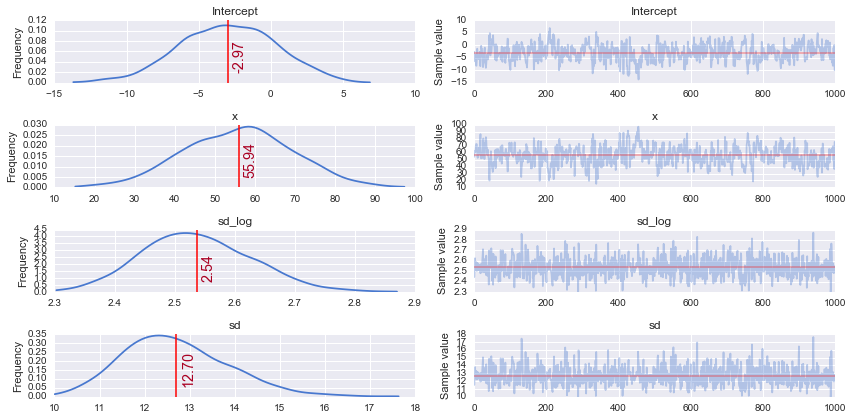

In [73]:
plot_traces(trace, retain=1000)

In [58]:
data = df.copy()
data = data[['pct_nonwhite', 'food_deserts']]
data.columns=['x','y']

## standardize (mean center and divide by 1 sd)
data = (data[['x','y']] - data[['x','y']].mean(0)) / data[['x','y']].std(0)
data['sigma_y'] = data['sigma_y'] / data['y'].std(0)
data['sigma_x'] = data['sigma_x'] / data['x'].std(0)


## create xlims ylims for plotting
xlims = (data['x'].min() - np.ptp(data['x'])/5
                 ,data['x'].max() + np.ptp(data['x'])/5)
ylims = (data['y'].min() - np.ptp(data['y'])/5
                 ,data['y'].max() + np.ptp(data['y'])/5)

## scatterplot the standardized data
g = sns.FacetGrid(data, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of ethnicity/food desert dataset after standardization', fontsize=16)


KeyError: 'sigma_y'

Lets look at the total percent of those living in a low access low income area.

Index([u'des_percent', u'perc_lali', u'urban_des', u'rural_des', u'n_urban',
       u'n_rural', u'LowIncomeTracts', u'low_vehicle_tracts',
       u'total_housing_units', u'pop_in_group_housing', u'pop_effected',
       u'state_pop_ratio', u'state_tract_ratio', u'cnty_obesity_pct_adj',
       u'cnty_dm_pct_adj', u'cnty_inactive_pct_adj', u'Adolescent_births',
       u'ABR', u'p_hs_edatt', u'PC_PHYS_R', u'DENTIST_R', u'PSYCH_R',
       u'PCT_WHITE', u'PCT_65OVER', u'PCT_18_64', u'PCT_UNDR18', u'PCT_UNDER5',
       u'unemployment_rate', u'n_hospitals', u'mort_30_ami', u'mort_30_cabg',
       u'mort_30_copd', u'mort_30_hf', u'mort_30_pn', u'mort_30_stk',
       u'readm_30_ami', u'readm_30_cabg', u'readm_30_copd', u'readm_30_hf',
       u'readm_30_hip_knee', u'readm_30_hosp_wide', u'readm_30_pn',
       u'readm_30_stk', u'std', u'vaccine_dx', u'food_dx', u'opiods_rx_1000',
       u'MILK_PRICE10', u'SODA_PRICE10', u'FFR07', u'pct_nonwhite'],
      dtype='object')

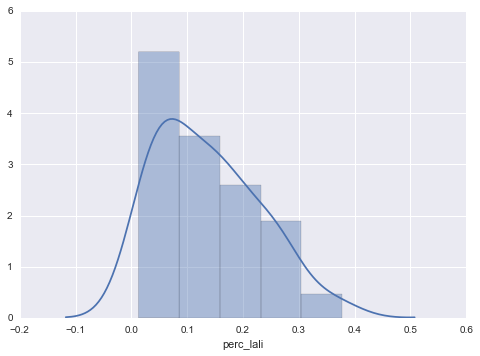

In [433]:
sns.distplot(df['perc_lali'])
df.columns

Sum of Squared Errors (SSE): 0


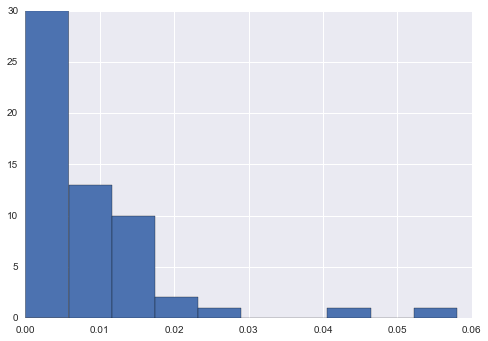

In [434]:
mean_expected_value = df['perc_lali'].mean()
Squared_errors = pd.Series(mean_expected_value - df['perc_lali'])**2
SSE = np.sum(Squared_errors)
print ('Sum of Squared Errors (SSE): %01.f' % SSE)
density_plot = Squared_errors.hist()


The plot shows how frequent certain errors are in respect of their values. Therefore, we can see that most errors are around zero (there is a high density around that value). Such a situation can be considered a good one, since in most cases the mean is a good approximation, but some errors are really very far from the zero and they can attain considerable values (don't forget that the errors are squared, anyway, so the effect is emphasized). When trying to  figure out such values, our approach will surely lead to a relevant error and we should find a way to minimize it using a more sophisticated approach.

Evidently, the mean is not a good representative of certain values, but it is certainly a good baseline to start from. Certainly, an important problem with the mean is
its being  xed, whereas the target variable is changeable. However, if we assume that the target variable changes because of the effect of some other variable we are measuring, then we can adjust the mean with respect to the variations in cause.

One improvement on our previous approach could be to build a mean conditional on certain values of another variable (or even more than one) actually related to our target, whose variation is somehow similar to the variation of the target one.  

Intuitively, if we know the dynamics we want to predict with our model, we can try to look for variables that we know can impact the answer values.   

In food deserts, we actually know that usually the larger a county population is,
the more food desert census tracts it will posess; however, this rule is just part of the story and the number of food deserts that are in a county is affected by many other considerations. For the moment, we will keep it simple and just assume that the obesity rate is a factor that negatively affects a counties well being, and consequently, results in more food deserts.  

Now, we have a variable that we know should change with our target and we just need to measure it and extend our initial formula based on constant values with something else.
In statistics, there is a measure that helps to measure how (in the sense of how much and in what direction) two variables relate to each other: 
#### correlation. ####
In correlation, a few steps are to be considered. First, your variables have to be standardized (or your result won't be a correlation but a covariation, a measure of association that is affected by the scale of the variables you are working with).

In statistical Z score standardization, you subtract from each variable its mean and then you divide the result by the standard deviation. The resulting transformed variable will have a mean of 0 and a standard deviation of 1 (or unit variance, since variance is the squared standard deviation).
The formula for standardizing a variable is as follows:

$$x = x-mean(x) / std(x)$$


After standardizing, you compare the squared difference of each variable with its own mean. If the two differences agree in sign, their multiplication will become positive (evidence that they have the same directionality); however, if they differ, the multiplication will turn negative. By summing all the multiplications between the squared differences, and dividing them by the number of observations, you will  finally get the correlation which will be a number ranging from -1 to 1.
The absolute value of the correlation will provide you with the intensity of the relation between the two variables compared, 1 being a sign of a perfect match and zero a sign of complete independence between them (they have no relation between them). The sign instead will hint at the proportionality; positive is direct (when one grows the other does the same), negative is indirect (when one grows, the other shrinks).


Covariance can be expressed as follows:

$$ cov(xi,y) = 1/n * sum(xi - mean(x1) * (y-mean(y)) $$

Whereas, Pearson's correlation can be expressed as follows:

$$ r = 1/n * {sum(xi - mean(x1) * (y-mean(y)) / std(xi * std(y)} $$

In [ ]:
def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

In [435]:
from scipy.stats.stats import pearsonr
print ('Our correlation estimation: %0.5f' % (correlation(df['cnty_obesity_pct_adj'], df['perc_lali'])))
print ('Correlation from Scipy pearsonr estimation: %0.5f' % pearsonr(df['cnty_obesity_pct_adj'], df['perc_lali'])[0])


Our correlation estimation: 0.33015
Correlation from Scipy pearsonr estimation: 0.33015


Our correlation estimation for the relation between the value of the target variable and the county unemployment rate in the area is  0.32989, which is positive and moderately strong, since the maximum positive score of a correlation is 1.0.

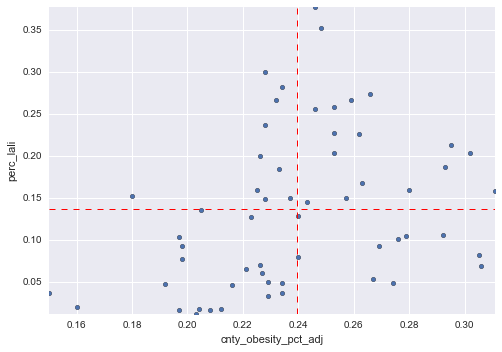

In [438]:
x_range = [df['cnty_obesity_pct_adj'].min(),df['cnty_obesity_pct_adj'].max()]
y_range = [df['perc_lali'].min(),df['perc_lali'].max()]
scatter_plot = df.plot(kind='scatter', x='cnty_obesity_pct_adj', y='perc_lali', xlim=x_range, ylim=y_range)
meanY = scatter_plot.plot(x_range, [df['perc_lali'].mean(),df['perc_lali'].mean()], '--' , color='red', linewidth=1)
meanX = scatter_plot.plot([df['cnty_obesity_pct_adj'].mean(),df['cnty_obesity_pct_adj'].mean()], y_range, '--', color='red', linewidth=1)


In [439]:
y = df['perc_lali']
X = df['cnty_obesity_pct_adj']
linear_regression = smf.ols(formula='perc_lali ~ cnty_obesity_pct_adj', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lali   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.851
Date:                Mon, 08 Aug 2016   Prob (F-statistic):             0.0114
Time:                        02:41:37   Log-Likelihood:                 59.719
No. Observations:                  58   AIC:                            -115.4
Df Residuals:                      56   BIC:                            -111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.0684      0.079     -0.865      0.391        -0.227     0.090
cnty_obesity_pct_adj     0.8557      0.327      2.617      0.011         0.201     1.511
==============================================================================
Omnibus:                        5.274   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.166
Skew:                           0.725   Prob(JB):                       0.0755
Kurtosis:                       2.808   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [440]:
print (fitted_model.params)
betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict()

Intercept              -0.068440
cnty_obesity_pct_adj    0.855659
dtype: float64


Most of these statistics make sense when we are dealing with more than one predictor variable, so they will be discussed in the next notebook. Thus, for the moment, as we are working with a simple linear regression, the two measures that are worth examining closely are F-statistic and R-squared.
_______
* F-statistic is actually a test that doesn't tell you too much if you have enough observations and you can count on a minimally correlated predictor variable. Usually it shouldn't be much of a concern in a data science project.  

* R-squared is instead much more interesting because it tells you how much better your regression model is in comparison to a single mean. It does so by providing you with a percentage of the unexplained variance of a mean as a predictor that actually your model was able to explain.

If you want to compute the measure yourself, you just have to calculate the sum of squared errors of the mean of the target variable. That's your baseline of unexplained variance (the variability in the percentage of population living in a food desert that in our example we want to explain by a model). If from that baseline you subtract the sum of squared errors of your regression model, you will get the residual sum of squared errors, which can be compared using a division with your baseline:

In [441]:
mean_sum_squared_errors = np.sum((df['perc_lali']-df['des_percent'].mean())**2)
regr_sum_squared_errors = np.sum((df['perc_lali']-fitted_values)**2)
(mean_sum_squared_errors-regr_sum_squared_errors) / mean_sum_squared_errors

0.11248999922961715

In [442]:
mean_sum_squared_errors

0.4880235922972601

In [443]:
regr_sum_squared_errors

0.43312581877570633

a linear regression can always work within the range of values it learned from (this is called interpolation) but can provide correct values for its learning boundaries
(a different predictive activity called extrapolation) only in certain conditions.

Standard errors instead are very important because they signal a weak or unclear relationship between the predictor and the answer. You can notice this by dividing the standard error by its beta. If the ratio is 0.5 or even larger, then it's a clear sign that the model has little con dence that it provided you with the right coef cient estimates. Having more cases is always the solution because it can reduce the standard errors of the coef cients and improve our estimates; however, there are also other methods to reduce errors, such as removing the redundant variance present among the features by a principal component analysis or selecting a parsimonious set of predictors by greedy selections. All these topics will be discussed when we work with multiple predictors; at this point in the book, we will illustrate the remedies to such a problem.

In [444]:
regr_sum_squared_errors/ betas
#fitted_model.summary()
# betas
# lr_model1.params

array([-6.32857038,  0.50618979])

In [445]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              perc_lali   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.851
Date:                Mon, 08 Aug 2016   Prob (F-statistic):             0.0114
Time:                        02:42:15   Log-Likelihood:                 59.719
No. Observations:                  58   AIC:                            -115.4
Df Residuals:                      56   BIC:                            -111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.0684      0.079     -0.865      0.391        -0.227     0.090
cnty_obesity_pct_adj     0.8557      0.327      2.617      0.011         0.201     1.511
==============================================================================
Omnibus:                        5.274   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.166
Skew:                           0.725   Prob(JB):                       0.0755
Kurtosis:                       2.808   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

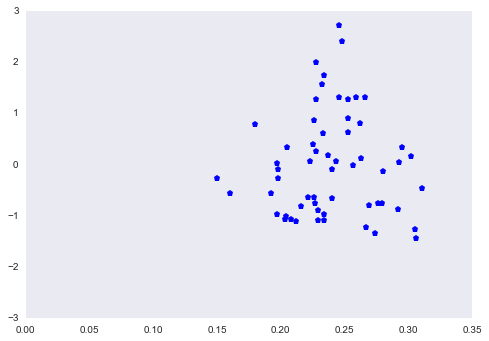

In [446]:
residuals = df['perc_lali']-fitted_values
normalized_residuals = standardize(residuals)
residual_scatter_plot = plt.plot(df['cnty_obesity_pct_adj'], normalized_residuals,'bp')
mean_residual = plt.plot([int(x_range[0]),round(x_range[1],0)], [0,0],'-', color='red', linewidth=2)
upper_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [3,3], '--', color='red', linewidth=1)
lower_bound = plt.plot([int(x_range[0]),round(x_range[1],0)], [-3,-3],'--', color='red', linewidth=1)
plt.grid()

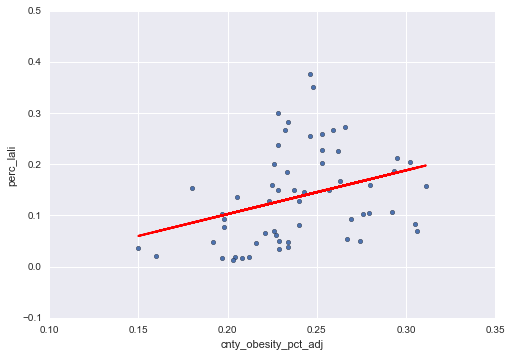

In [447]:
df.plot(kind='scatter', x='cnty_obesity_pct_adj', y='perc_lali')
plt.plot(pd.DataFrame(df['cnty_obesity_pct_adj']),fitted_values,c='red',linewidth=2)


In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
x_cols=[ 'percent_food_desert','unemployment_rate', 'unemployment_rate', 'cnty_obesity_pct_adj','cnty_inactive_pct','cnty_obesity_pct', 'PCT_18_64','p_hs_edatt','NUMGQTRS'] 
#x_cols=['PCT_18_64','p_hs_edatt','NUMGQTRS','cnty_inactive_pct'] 

data = df[x_cols]

model = forward_selected(data, 'percent_food_desert')

print model.model.formula

print model.rsquared_adj


In [ ]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
 
#Load boston housing dataset as an example
X =data.drop("pop2010_in_des",axis=1)
X=X.values
Y = data["pop2010_in_des"].values
names = data.columns
 
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
for i in range(X.shape[1]):
    score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2", cv=ShuffleSplit(len(X), 3, .3))
    scores.append((round(np.mean(score), 3), names[i]))
print sorted(scores, reverse=True)

In [ ]:
feats=pd.DataFrame(sorted(scores, reverse=True),columns=['importance','feature'])
feats.plot(kind='bar')
feats

In [ ]:

def plot_importances(X_train, importances, f_rank):
    '''
    :param X_train: Dataframe containing predictor variables of training set
    :param importances: List of feature importance, obtained from try_forest
    :param f_rank: Feature ranking, obtained from sort_features()
    :return: None, plot saved as 'Forest_feature_importances.png'
    '''
    plt.title('Feature Importances according to Random Forest')
    plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
    plt.xticks(range(X_train.shape[1]), f_rank, rotation=45)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()

In [ ]:
sns.barplot(x=feats['feature'][:5],y=feats['importance'][:5])

In [ ]:
# calculate the correlation matrix
corr_dataframe = data.corr()

# compute hierarchical cluster on both rows and columns for correlation matrix and plot heatmap 
def corr_heatmap(corr_dataframe):
    import scipy.cluster.hierarchy as sch
    
    corr_matrix = np.array(corr_dataframe)
    col_names = corr_dataframe.columns
    
    Y = sch.linkage(corr_matrix, 'single', 'correlation')
    Z = sch.dendrogram(Y, color_threshold=0, no_plot=True)['leaves']
    corr_matrix = corr_matrix[Z, :]
    corr_matrix = corr_matrix[:, Z]
    col_names = col_names[Z]
    im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto', cmap='bwr')
    plt.colorbar()
    plt.xticks(range(corr_matrix.shape[0]), col_names, rotation='vertical', fontsize=4)
    plt.yticks(range(corr_matrix.shape[0]), col_names[::-1], fontsize=4)
    
# plot
corr_heatmap(corr_dataframe)

In [ ]:

def remove_high_corr(corr_dataframe, thresh = 0.9):
    '''remove predictors with high pairwise correlation'''
    abs_corr = np.abs(corr_dataframe).as_matrix() # absolute correlation matrix
    col_names = list(corr_dataframe.columns)
    
    # set up diagonal to 0
    np.fill_diagonal(abs_corr, 0)
    
    print "Removed predictors (in order): \n"
    while np.max(abs_corr) >= thresh:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape) # find maximum element
        # print abs_corr[i, j]
        rdx = which_to_remove(i, j, abs_corr)
        # remove corresponding predictor
        print col_names.pop(rdx)
        abs_corr = np.delete(abs_corr, rdx, 0)
        abs_corr = np.delete(abs_corr, rdx, 1)
        
    return col_names

def which_to_remove(i, j, abs_corr):
    '''compare two predictors and remove the one with higher abs correlation with other predictors'''
    i_absmean = np.mean(abs_corr[i, np.where(abs_corr[i,:] == 0)])
    j_absmean = np.mean(abs_corr[j, np.where(abs_corr[j,:] == 0)])
    
    return i if i_absmean > j_absmean else j

# remained predictors
col_remained = remove_high_corr(corr_dataframe)
data=data[col_remained]
corr_dataframe = data.corr()

corr_heatmap(corr_dataframe)

In [ ]:
col_remained = remove_high_corr(corr_dataframe)
data = df[col_remained]
corr_dataframe = data.corr()
corr_heatmap(corr_dataframe)

In [ ]:
corrmat = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [ ]:
model.summary()

In [ ]:

from bokeh.charts import Histogram
from bokeh.charts import defaults, vplot, hplot, show, output_file
from bokeh.io import output_notebook 
output_notebook()


# input options
hist = Histogram(df['pop2010_in_des'], title="df['pop2010_in_des']")
show(hist)
#df['pop2010_in_des']